# Fitbit Charge 6: Guide to data extraction and analysis

<img src="https://imgur.com/nR08yax.png" width="300">

_A picture of the Fitbit Charge 6 that was used for this notebook_

The Fitbit Charge 6 is a new version of the Fitbit Charge series. We have covered the data extraction and analysis for the Fitbit Charge 4 in [this notebook](https://github.com/Stanford-Health/wearable-notebooks/blob/main/notebooks/fitbit_charge_4.ipynb), and you can extract any data that you can extract from the Fitbit Charge 4, also from the Fitbit Charge 6!

What we will be covering in this notebook will be **intraday** data specifically. Here is a list of high frequency data that can be extracted from any Fitbit watch.

Data | Frequency of Sampling
:-------------------:|:----------------------:
intraday_breath_rate | per sleep
intraday_active_zone_minute | per minute
intraday_activity | per minute
heart_rate | per second
intraday_hrv | per 5 minutes during sleep
intraday_spo2 | per minute during sleep

In this guide, we sequentially cover the following **nine** topics to extract data from the Fitbit API:


1. **Setup**
    - 1.1: Data receiver setup
    - 1.2: Study participant setup
    - 1.3: Library imports
2. **Authentication and Authorization**
3. **Data Extraction**
    - Select the dates to extract data
4. **Data Exporting**
    - We export all of this data to CSV, Excel and JSON
5. **Adherence**
    - We detect when the user isn't using the device by plotting a block plot
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced Visualization**
    - 7.1: Replicating a graph of heart rate over time in the app
8. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
9. **Statistical Data Analysis**
    - 9.1: Sleep apnea detection from SPO2 and breathing rate during sleep
    - 9.2: Distribution of breathing rates during different stage of sleep


*Note: Full documentation of APIs by Fitbit can be found [here](https://dev.fitbit.com/build/reference).

# 1. Setup
## 1.1 Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Fitbit account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter in section 1.2.

To extract data from the Fitbit, you will first need to log in to the fitbit account at [https://dev.fitbit.com/login](https://dev.fitbit.com/login) by using the email and password that you registered. Click "REGISTER AN APP" on the menu bar, which should lead you to the application form.

For redirect url where you will receive the access token, you can fill in the local host https://127.0.0.1/8080, but any redirect url should work fine. **To access intraday data without additional request forms, select OAuth 2.0 Application Type to be "Personal".** Other entries can be filled in without particular specifications. An example is shown below.

<img src="https://imgur.com/ATwWvA8.png" width="600">

After you have agreed to the terms of service and clicked register, you should be able to see your client id and client secrete in "Applications I registered":

<img src="https://imgur.com/qnSnvud.png" width="600">

Your client id and client secret will be needed to obtain the access token as described in section 2.

## 1.2 Study Participant setup
Dear participant,

Please start by charging the watch and connecting it to your account. Your login credentials should be provided by the research coordinator. Please download the Fitbit app from the appstore/playstore and start using your Fitbit. Remember to sync the device every few days. Otherwise, the collected high frequency data will be converted to low frequency summary for certain data types.

Best,

Wearipedia

## 1.3 Library imports

Now that we have the Fitbit and application setup, we can start using wearipedia to extract and simulate data. We will start by importing `wearipedia` itself.

In [50]:
!pip install wearipedia
import wearipedia

Next, we will import all other necessary libraries. These include `matplotlib` for graph plotting, `pandas`, `numpy`, `scipy` for data processing and statistical analysis.

In [51]:
import base64
import hashlib
import html
import json
import os
import re
import urllib.parse
import requests
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.covariance import EllipticEnvelope
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter
import numpy as np

# 2. Authentication and Authorization

In this section, we will cover user authentication with `wearipedia`. You will need your client id and client secret from section 1.1.

In [52]:
#@title Insert client_id and client_secret

CLIENT_ID = "23QFQB" #@param {type:"string"}
CLIENT_SECRET = "47bc55e60994f8a522987c19ef114a9b" #@param {type:"string"}
access_token = ""

Next, you can specify the start date and end date of the data that you would like to extract (or simulate).

In [53]:
#@title Enter start date and end data for data extraction/simulation

START_DATE = "2024-12-01" #@param {type:"string"}
END_DATE = "2024-12-10" #@param {type:"string"}
params = {"seed": 100, "start_date": START_DATE, "end_date": END_DATE}

Now, we will initialize the device object for the Fitbit Charge 6. We will also specify if we will use real data. Check the box if you would like to use synthetic data instead of real data.

*If you choose to use real data*, running the cell below should prompt you to click on an url. This will redirect you to your redirect url that you have chosen when you registered for an app. Please check all boxes to access all available data. Afterwards, copy the url in the address bar and paste in the box below.

<img src="https://imgur.com/Hh8Jbaz.png" width="400">




In [54]:
device = wearipedia.get_device("fitbit/fitbit_charge_6")

synthetic = True #@param {type:"boolean"}
if not synthetic:
  # If the data is not synthetic, authenticate using the access token
  device.authenticate(access_token)

# 3. Data Extraction

Now we are ready to extract data from the Fitbit device. To extract data, simply call the `get_data` function with the data type you would like to extract. The types of intraday data available are `"intraday_breath_rate"`, `"intraday_active_zone_minute"`, `"intraday_activity"`, `"heart_rate"`, `"intraday_hrv"` and `"intraday_spo2"`.

Since intraday data is high frequency data, there is a lot of data to be extracted/generated. It should take a while for the data to be retrieved.

Note also that the Fitbit API has a limit of 150 requests per user per hour, and each day of intraday data requires one API request. It might be prudent to export the data soon after it's fetched. Note that this also means you can at one time export at most 150 days of data. If the API is returning a 429 code, this means that you've run out of requests for the hour.

In [55]:
br = device.get_data("intraday_breath_rate", params)
azm = device.get_data("intraday_active_zone_minute", params)
activity = device.get_data("intraday_activity", params)
hr = device.get_data("intraday_heart_rate", params)
hrv = device.get_data("intraday_hrv", params)
spo2 = device.get_data("intraday_spo2", params)

<!-- Let's take a look at the data that is extracted! As an example, the active zone minute (azm) has the following format. Other data types also follow a similar dictionary format. -->

In [56]:
azm

[{'activities-active-zone-minutes-intraday': [{'dateTime': '2024-01-01',
    'minutes': [{'minute': '00:00:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:01:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:02:00',
      'value': {'fatBurnActiveZoneMinutes': 1, 'activeZoneMinutes': 1}},
     {'minute': '00:03:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:04:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:05:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:06:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:07:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:08:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:09:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:10:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:11:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:12:00', 'value': {'activeZoneMinutes': 0}},
     {'minute': '00:13:00', 'value': {'activeZo

At first glance, we can see that this dictionary contains some information about cardio active zone minutes, active zone minutes, and their corresponding recorded time during the day. Each minute, the fitbit determines if the user is in fat burn, cardio, or peak heart rate zone, and convert it into "active zone minutes". activeZoneMinutes is simply a total count of active zone minutes earned. For more information, you can refer to the fitbit web API [active zone minute endpoint description](https://dev.fitbit.com/build/reference/web-api/intraday/get-azm-intraday-by-date/).

Although the data looks a bit messy, it is important to understand the structure of the extracted data so that we can reorganize it into a format we want (we will demonstrate organizing the data into dataframes in upcoming sections).

In [57]:
print(f"Number of days with azm recorded: {len(azm)}")

Number of days with azm recorded: 30


In [58]:
# For the i-th day, the dictionary containing the AZM data can be access via azm[i]['activities-active-zone-minutes-intraday'][0]
# Let's look at the data for the first day!

azm[0]['activities-active-zone-minutes-intraday'][0]

{'dateTime': '2024-01-01',
 'minutes': [{'minute': '00:00:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:01:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:02:00',
   'value': {'fatBurnActiveZoneMinutes': 1, 'activeZoneMinutes': 1}},
  {'minute': '00:03:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:04:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:05:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:06:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:07:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:08:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:09:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:10:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:11:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:12:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:13:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': '00:14:00', 'value': {'activeZoneMinutes': 0}},
  {'minute': 

The above dictionary has two keys -- `'dateTime'` and `'minutes'`. `'dateTime'` contains the date of the AZM data, and `'minutes'` is a list of dictionaries, each containing the AZM information and the minute during the daya at which it was recorded.

# 4. Data Exporting

In this section, we export all of this data to JSON, which with popular scientific computing software (R, Matlab). We export each datatype separately and also export a complete version that includes all simultaneously.

In [61]:
# Define a custom JSON encoder to handle NumPy data types
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        # Let the base class default method raise the TypeError for other non-serializable types
        return json.JSONEncoder.default(self, obj)

#@title Select which format to export data

# set which format you prefer to export
use_JSON = True #@param {type:"boolean"}
use_CSV = True #@param {type:"boolean"}
use_Excel = True #@param {type:"boolean"}

if use_JSON:
  # Use json.dump with the custom NpEncoder for all variables
  # Add indent=4 for human-readable output
  json.dump(br, open("br.json", "w"), cls=NpEncoder, indent=4)
  json.dump(azm, open("azm.json", "w"), cls=NpEncoder, indent=4)
  json.dump(activity, open("activity.json", "w"), cls=NpEncoder, indent=4)
  json.dump(hr, open("hr.json", "w"), cls=NpEncoder, indent=4)
  json.dump(hrv, open("hrv.json", "w"), cls=NpEncoder, indent=4)
  json.dump(spo2, open("spo2.json", "w"), cls=NpEncoder, indent=4)

  complete = {
      "br": br,
      "azm": azm,
      "activity": activity,
      "hr": hr,
      "hrv": hrv,
      "spo2": spo2,
  }

  json.dump(complete, open("complete.json", "w"), cls=NpEncoder, indent=4)

if use_CSV:
  # These lines will attempt to convert to DataFrame first, which should be fine
  # as long as br, azm etc are lists of dictionaries that pandas can convert.
  pd.DataFrame(br).to_csv("br.csv", index=False)
  pd.DataFrame(azm).to_csv("azm.csv", index=False)
  pd.DataFrame(activity).to_csv("activity.csv", index=False)
  pd.DataFrame(hr).to_csv("hr.csv", index=False)
  pd.DataFrame(hrv).to_csv("hrv.csv", index=False)
  pd.DataFrame(spo2).to_csv("spo2.csv", index=False)


if use_Excel:
  # Same as CSV, these should be fine if lists are convertible to DataFrames
  pd.DataFrame(br).to_excel("br.xlsx", index=False)
  pd.DataFrame(azm).to_excel("azm.xlsx", index=False)
  pd.DataFrame(activity).to_excel("activity.xlsx", index=False)
  pd.DataFrame(hr).to_excel("hr.xlsx", index=False)
  pd.DataFrame(hrv).to_excel("hrv.xlsx", index=False)
  pd.DataFrame(spo2).to_excel("spo2.xlsx", index=False)

# 5. Data Adherence

In this section, we will simulate non-adherence over long periods of time. We will demonstrate this with the heart rate data. First, we will have to extract the time and corresponding heart rate value from our raw json format.

In [87]:
from datetime import datetime
import pandas as pd

results = []

for i, record in enumerate(hr): # Using enumerate to help identify problematic records by index
    try:
        # Access 'activities-heart' nested inside 'heart_rate_day'
        # This part was corrected based on your new data structure
        daily_heart_data = record["heart_rate_day"][0]["activities-heart"][0]
        date_str = daily_heart_data["dateTime"]

        # The intraday data is also nested within 'heart_rate_day'
        dataset = record["heart_rate_day"][0]["activities-heart-intraday"]["dataset"]

        date_obj = datetime.strptime(date_str, "%Y-%m-%d").date()

        for entry in dataset:
            time_str = entry["time"]
            heart_rate_value = entry["value"]

            time_obj = datetime.strptime(time_str, "%H:%M:%S").time()

            date_time = datetime.combine(date_obj, time_obj)

            results.append([date_time, heart_rate_value])

    except KeyError as e:
        print(f"Skipping record {i} due to missing key or incorrect path: {e}. Record content (first 200 chars): {str(record)[:200]}...")
    except IndexError as e:
        print(f"Skipping record {i} due to empty list or index out of bounds: {e}. Record content (first 200 chars): {str(record)[:200]}...")
    except Exception as e: # Catch any other unexpected errors during processing a record
        print(f"Skipping record {i} due to an unexpected error: {e}. Record content (first 200 chars): {str(record)[:200]}...")


# After the loop, create the DataFrame from the successfully processed results
df = pd.DataFrame(results, columns=["datetime", "heart_rate"])
df['datetime'] = pd.to_datetime(df['datetime'])

# Diagnostic prints (keep these for debugging, you can remove them later)
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
print(df.info()) # Check data types and non-null counts
print("\nHeart Rate Value Counts:")
print(df['heart_rate'].value_counts(dropna=False).head()) # Check common values, including zeros and NaNs


DataFrame Head:
             datetime  heart_rate
0 2024-01-01 00:00:00   81.731496
1 2024-01-01 00:00:01   82.731496
2 2024-01-01 00:00:02   81.731496
3 2024-01-01 00:00:03   82.731496
4 2024-01-01 00:00:04   82.731496

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592000 entries, 0 to 2591999
Data columns (total 2 columns):
 #   Column      Dtype         
---  ------      -----         
 0   datetime    datetime64[ns]
 1   heart_rate  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.6 MB
None

Heart Rate Value Counts:
heart_rate
50.000000     1113412
195.000000     619492
84.326775        1115
87.326775        1102
86.326775        1091
Name: count, dtype: int64


In [76]:
print(df)

                   datetime  heart_rate
0       2024-01-01 00:00:00   81.731496
1       2024-01-01 00:00:01   82.731496
2       2024-01-01 00:00:02   81.731496
3       2024-01-01 00:00:03   82.731496
4       2024-01-01 00:00:04   82.731496
...                     ...         ...
2591995 2024-01-30 23:59:55   50.000000
2591996 2024-01-30 23:59:56   50.000000
2591997 2024-01-30 23:59:57   50.000000
2591998 2024-01-30 23:59:58   50.000000
2591999 2024-01-30 23:59:59   50.000000

[2592000 rows x 2 columns]


Since our simulated data has data entries for all timesteps, in order to simulate non-adherence, we will randomly select a portion of data to be None. We will first select 30% of the dates among all dates in the dataframe on which non-adherence occurs.

In [91]:
# Dynamically define START_DATE and END_DATE from your DataFrame's datetime range.
# This is crucial to ensure the reindex covers the full span of your data.
START_DATE = df['datetime'].min().strftime("%Y-%m-%d")
END_DATE = df['datetime'].max().strftime("%Y-%m-%d")
# --------------------------------------------------------------------------

seed_value = 42
np.random.seed(seed_value)

unique_dates = df['datetime'].dt.date.unique()
selected_dates = np.random.choice(unique_dates, size=int(len(unique_dates) * 0.3), replace=False)



In order for the nonadherence to be realistic, we will select random intervals that are hours long where there is no data recorded -- instead of random entries -- to be `None` (after all, the user won't take of the watch for one second and put on the watch another second!).

In [90]:
import random

random.seed(seed_value)

def create_random_intervals(date):
    intervals = []
    num_intervals = random.choice([1, 2])
    for _ in range(num_intervals):
        start_hour = random.randint(0, 23)
        start_minute = random.randint(0, 59)
        start_second = random.randint(0, 59)
        start_time = pd.Timestamp(date) + pd.Timedelta(hours=start_hour, minutes=start_minute, seconds=start_second)

        duration_hours = random.randint(0, 5)
        duration_minutes = random.randint(0, 59)
        duration_seconds = random.randint(0, 59)
        end_time = start_time + pd.Timedelta(hours=duration_hours, minutes=duration_minutes, seconds=duration_seconds)

        intervals.append((start_time, end_time))
    return intervals

In [79]:
intervals_to_nullify = []
for date in selected_dates:
    intervals_to_nullify.extend(create_random_intervals(date))

intervals_to_nullify = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in intervals_to_nullify]

Since in the real data, the fitbit doesn't record when the user is not using the watch, in our synthetic we will delete those rows which have value `None`.

In [93]:
# Reindex non_adherence_df using the complete date range
non_adherence_df = non_adherence_df.set_index('datetime').reindex(date_range).reset_index()

# Replace NaN values in heart_rate with None (this is okay)
non_adherence_df['heart_rate'] = non_adherence_df['heart_rate'].apply(lambda x: None if pd.isna(x) else x)

# Reset column names if needed
non_adherence_df.columns = ['datetime', 'heart_rate']

# Diagnostics for non_adherence_df after reindexing (keep these for debugging)
print(f"\nShape of non_adherence_df AFTER reindexing: {non_adherence_df.shape}")
print(f"Count of NaNs in 'heart_rate' AFTER reindexing: {non_adherence_df['heart_rate'].isna().sum()}")
print("Value counts for 'heart_rate' AFTER reindexing (showing NaNs):")
print(non_adherence_df['heart_rate'].value_counts(dropna=False).head())


Shape of non_adherence_df AFTER reindexing: (2592000, 2)
Count of NaNs in 'heart_rate' AFTER reindexing: 112233
Value counts for 'heart_rate' AFTER reindexing (showing NaNs):
heart_rate
50.000000     1067367
195.000000     593430
NaN            112233
84.326775        1115
87.326775        1102
Name: count, dtype: int64


Next, we can specify the start date and end date to visualize. We will also plot a block plot to visualize the dates and times of when the user had used the watch.

To plot the block plot, we plot a value of 1 if a valid heart rate value is recorded. Otherwise, we plot a value of 0.


--- Pre-Plotting Data Check ---
Shape of selected_rows_copy: (2592000, 2)
Value counts for 'heart_rate' in selected_rows_copy (after 0/1 conversion):
heart_rate
1    2479767
0     112233
Name: count, dtype: int64


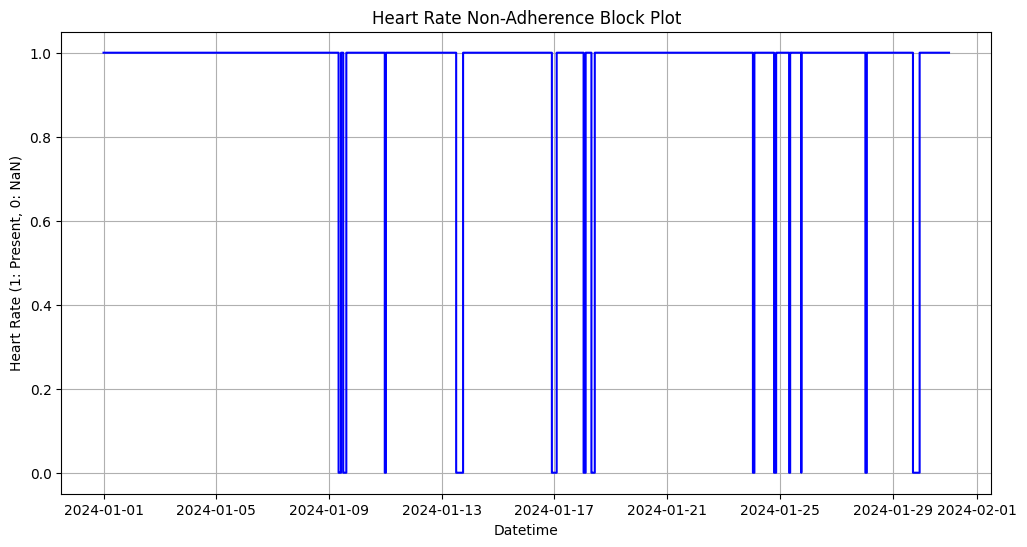

In [94]:
VISUAL_START_DATE = "2024-01-01" #@param {type:"string"}
VISUAL_END_DATE = "2024-12-30" #@param {type:"string"}

visual_start_date = pd.to_datetime(VISUAL_START_DATE)
visual_end_date = pd.to_datetime(VISUAL_END_DATE)

selected_rows = non_adherence_df[(non_adherence_df['datetime'] >= visual_start_date) &
                                 (non_adherence_df['datetime'] < visual_end_date)]

# This line transforms actual heart rate values to 1 and NaNs to 0 for the block plot
selected_rows_copy = selected_rows.copy()
selected_rows_copy['heart_rate'] = selected_rows_copy['heart_rate'].apply(lambda x: 1 if pd.notna(x) else 0)

# Diagnostic prints for selected_rows_copy (keep these for debugging)
print("\n--- Pre-Plotting Data Check ---")
print("Shape of selected_rows_copy:", selected_rows_copy.shape)
print("Value counts for 'heart_rate' in selected_rows_copy (after 0/1 conversion):")
print(selected_rows_copy['heart_rate'].value_counts(dropna=False))


# Plot a block plot
plt.figure(figsize=(12, 6))
plt.plot(selected_rows_copy['datetime'], selected_rows_copy['heart_rate'], drawstyle='steps-post', color='blue')
plt.title('Heart Rate Non-Adherence Block Plot')
plt.xlabel('Datetime')
plt.ylabel('Heart Rate (1: Present, 0: NaN)')
plt.grid(True)
plt.show()

# 6. Visualization

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

Similar to the previous section, we would first have to reorganize our raw JSON format data.

In [101]:
# Reorganize heart rate data
hr_df = df.copy()

# Reorganize breath rate data
extracted_data = []
for entry in br:
    for br_entry in entry['br']:
        row = {
            'datetime': br_entry['dateTime'],
            'deepSleepSummary': br_entry['value']['deepSleepSummary']['breathingRate'],
            'remSleepSummary': br_entry['value']['remSleepSummary']['breathingRate'],
            'fullSleepSummary': br_entry['value']['fullSleepSummary']['breathingRate'],
            'lightSleepSummary': br_entry['value']['lightSleepSummary']['breathingRate']
        }
        extracted_data.append(row)

br_df = pd.DataFrame(extracted_data)
br_df['datetime'] = pd.to_datetime(br_df['datetime'])

# Reorganize hrv data
rmssd_data = []
for entry in hrv:
    for hrv_entry in entry['hrv']:
        for minute_entry in hrv_entry['minutes']:
            rmssd_data.append({'minute': minute_entry['minute'], 'rmssd': minute_entry['value']['rmssd']})

rmssd_df = pd.DataFrame(rmssd_data)
rmssd_df['minute'] = pd.to_datetime(rmssd_df['minute'])

lf_hf_data = []
for entry in hrv:
    for hrv_entry in entry['hrv']:
        for minute_entry in hrv_entry['minutes']:
            lf_hf_data.append({'minute': minute_entry['minute'], 'lf': minute_entry['value']['lf'], 'hf': minute_entry['value']['hf']})

lf_hf_df = pd.DataFrame(lf_hf_data)
lf_hf_df['minute'] = pd.to_datetime(lf_hf_df['minute'])

# Reorganize spo2 data
minute_value_data = []
for entry in spo2:
    for minute_entry in entry['minutes']:
        minute_value_data.append({'minute': minute_entry['minute'], 'value': minute_entry['value']})

spo2_df = pd.DataFrame(minute_value_data)
spo2_df['minute'] = pd.to_datetime(spo2_df['minute'])

We will plot graphs to visualize the following data:
- Heart rate (per second)
- Heart rate variability (hrv) in terms of Root Mean Square of Successive Differences (RMSSD)
- Heart rate variability (hrv) in terms of the power in interbeat interval fluctuations within the low frequency band and high frequency band ([see description from Fitbit web api](https://dev.fitbit.com/build/reference/web-api/intraday/get-hrv-intraday-by-date/))
- SPO2 (per minute during sleep)
- Average breathing rate during each sleep stage (per sleep).

Here, you can specify the visualization start date and end date.

In [105]:
VISUALIZATION_START_DATE = "2024-01-01" #@param {type:"string"}
VISUALIZATION_END_DATE = "2024-01-08" #@param {type:"string"}

visualization_start_date = pd.to_datetime(VISUALIZATION_START_DATE)
visualization_end_date = pd.to_datetime(VISUALIZATION_END_DATE)

In [106]:
selected_hr_df = hr_df[(hr_df['datetime'] >= visualization_start_date) & (hr_df['datetime'] < visualization_end_date)]
selected_br_df = br_df[(br_df['datetime'] >= visualization_start_date) & (br_df['datetime'] < visualization_end_date)]
selected_rmssd_df = rmssd_df[(rmssd_df['minute'] >= visualization_start_date) & (rmssd_df['minute'] < visualization_end_date)]
selected_lf_hf_df = lf_hf_df[(lf_hf_df['minute'] >= visualization_start_date) & (lf_hf_df['minute'] < visualization_end_date)]
selected_spo2_df = spo2_df[(spo2_df['minute'] >= visualization_start_date) & (spo2_df['minute'] < visualization_end_date)]

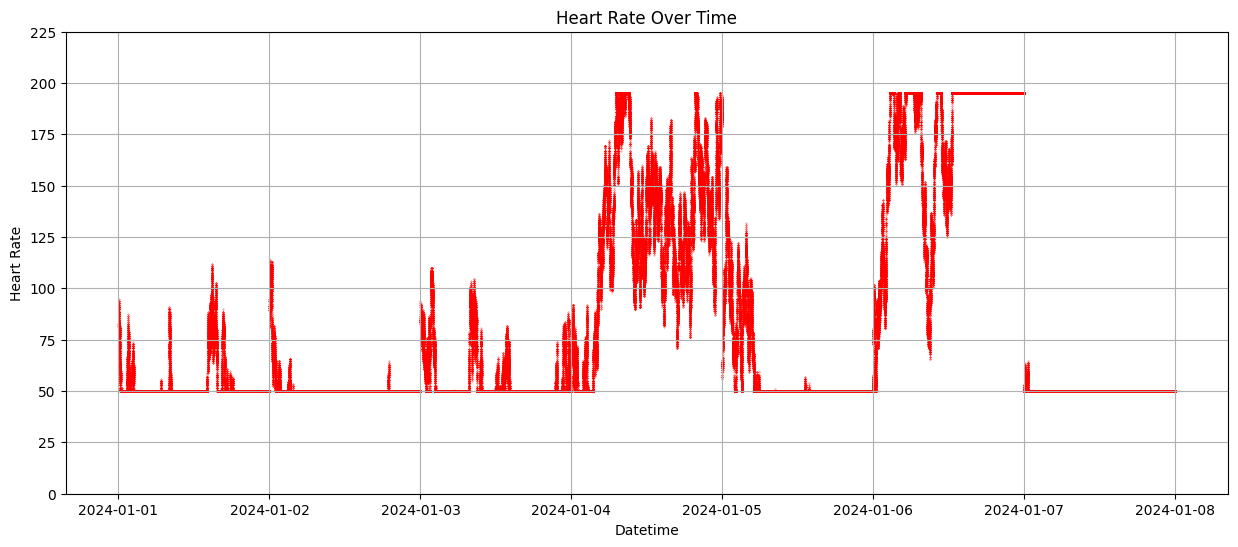

In [107]:
#@title Select the data to plot

feature = "heart rate" #@param ["heart rate", "breathing rate", "hrv (rmssd)", "hrv (lf and hf)", "spo2"]

if feature == "heart rate":
  plt.figure(figsize=(15, 6))
  plt.grid(True)
  plt.scatter(selected_hr_df['datetime'], selected_hr_df['heart_rate'], color='red', s=0.1, alpha=0.7)
  plt.title('Heart Rate Over Time')
  plt.xlabel('Datetime')
  plt.ylabel('Heart Rate')
  plt.ylim(0, 225)

  plt.show()
elif feature == "breathing rate":
  plt.figure(figsize=(15, 6))

  for column in selected_br_df.columns[1:]:
      plt.plot(selected_br_df['datetime'], selected_br_df[column], label=column)

  plt.title('Breath rate on selected dates')
  plt.xlabel('Date')
  plt.ylabel('Breathing rate')
  plt.xticks(rotation=45)
  plt.ylim(0, 25)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
elif feature == "hrv (rmssd)":
  plt.figure(figsize=(15, 6))
  plt.scatter(selected_rmssd_df['minute'], selected_rmssd_df['rmssd'], color='red', s=0.5)
  plt.title('HRV (RMSSD) Over Time')
  plt.xlabel('Datetime')
  plt.ylabel('RMSSD')
  plt.ylim(0, 100)
  plt.grid(True)
  plt.show()
elif feature == "hrv (lf and hf)":
  plt.figure(figsize=(15, 6))
  for band in ["lf", "hf"]:
    if band == "hf":
      color = "red"
    else:
      color = "green"
    plt.scatter(selected_lf_hf_df['minute'], selected_lf_hf_df[band], color=color, s=0.5, label=band)

  plt.legend()
  plt.title('HRV (lf and hf) Over Time')
  plt.xlabel('Datetime')
  plt.ylabel('Power (ms^2)')
  plt.ylim(0, 1200)
  plt.grid(True)
  plt.show()
else:
  plt.figure(figsize=(15, 6))
  plt.scatter(selected_spo2_df['minute'], selected_spo2_df['value'], color='blue', s=0.1)
  plt.title('SPO2 Over Time')
  plt.xlabel('Datetime')
  plt.ylabel('SPO2 (%)')
  plt.ylim(90, 100)
  plt.grid(True)
  plt.show()



# 7. Advanced Visualization

In this section, we will try more advanced data visualization, by replicating some plots from the fitbit. This will more manual adjustments for positioning texts, customizing colors, etc.

## 7.1 Heart rate in a day

Here we are going to try replicating this plot of heart rate versus time in the day from the fitbit app. The main feature is that the plot indicates the heart rate zone the time intervals during the day corresponds to. It provides a visual representation of how heart rate varies throughout the day. This can reveal patterns such as spikes during exercise, dips during sleep, or variations in response to stress or activity.

<img src="https://imgur.com/Goz1UD2.png" width="300">

In [110]:
from datetime import timedelta

DAY = "2024-01-03"
vis_day = pd.to_datetime(DAY)
vis_end_day = vis_day + timedelta(days = 1)
DAY_hr_df = hr_df[(hr_df['datetime'] >= vis_day) & (hr_df['datetime'] < vis_end_day)]
DAY_hr_df = DAY_hr_df.reset_index(drop=True)

DAY_hr_df['datetime'] = pd.to_datetime(DAY_hr_df['datetime'])

specific_times = ['00:00:00', '06:00:00', '12:00:00', '18:00:00', '23:59:00']

time_stamps = [pd.to_datetime(f"{DAY} {time}") for time in specific_times]

In [ ]:
with plt.style.context('dark_background'):
    # Creating the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(3, 5.5)
    plt.plot(DAY_hr_df['datetime'], DAY_hr_df['heart_rate'], color='#4DC3C3', lw=0.5)

    fig.patch.set_facecolor('#097194')
    plt.gca().set_facecolor('#097194')

    # Adjusting the labels
    plt.xticks(ticks=time_stamps, labels=['12', '6', '12PM', '6', '12'])
    plt.ylim(top=200, bottom=40)

    # Removing the borders from four sides
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Adjust tick sizes
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)

    # Adding labels
    plt.figtext(0.5, 1.0, "Dec 30, 2024", fontsize=14, ha='center', color='w')
    plt.figtext(0.5, 0.96, 'Beats Per Minute', fontsize=14, ha='center', color='w', fontweight='bold')

    for i in range(len(DAY_hr_df) - 1):
        hr = DAY_hr_df.iloc[i]['heart_rate']
        hr_next = DAY_hr_df.iloc[i + 1]['heart_rate']
        time = DAY_hr_df.iloc[i]['datetime']
        time_next = DAY_hr_df.iloc[i + 1]['datetime']

        if 110 <= hr <= 136:
            color = 'yellow'
        elif 136 < hr <= 169:
            color = 'orange'
        elif hr > 169:
            color = 'red'
        else:
            color = '#4DC3C3'

        plt.plot([time, time_next], [hr, hr_next], color=color, lw=0.5)

    # Adding the legend with colored squares
    legend_labels = ['Fat Burn', 'Cardio', 'Peak']
    legend_colors = ['yellow', 'orange', 'red']
    y_position = 0.92
    x_positions = [0.20, 0.45, 0.65]
    square_size = 9

    for i, (label, color) in enumerate(zip(legend_labels, legend_colors)):
        plt.figtext(x_positions[i], y_position + 0.01, '■', fontsize=square_size, color=color, va='center')
        plt.figtext(x_positions[i] + 0.05, y_position, label, fontsize=9, ha='left', color='w', fontweight='light')

    plt.show()

# 8. Outlier Detection and Data Cleaning

In data analysis, outliers are data points that significantly differ from the rest. They might indicate measurement variability or errors. For BPM data, outliers could signal physiological anomalies, errors, or artifacts.
Unconditional Outlier Detection, $P(\text{BPM})$

This approach examines each BPM measurement independently. It aims to identify data points that deviate substantially from the overall BPM distribution, without considering time sequence.
### Unconditional Outlier Detection:

#### Standard Deviation Method:

- Assumes BPM values follow a normal distribution.
- Identifies values beyond a certain number of standard deviations from the mean as outliers.
- Typically uses a cutoff between 1 and 4 standard deviations.

#### Interquartile Range (IQR) Method:
- Doesn't assume normal data distribution.
- Computes IQR between the 25th and 75th percentiles.
- Considers data points below $\text{Q1} - 1.5\times\text{IQR}$ or above $\text{Q3} + 1.5\times\text{IQR}$ as outliers.

### Conditional Outlier Detection, $P(\text{BPM}_{t}\mid\text{BPM}_{t-1})$

This method evaluates each BPM reading considering its preceding value. This is important because BPM values are correlated over time, especially in short intervals like 10 seconds.
Methods for Conditional Outlier Detection:

#### Change Detection:
- Calculates the difference between consecutive BPM readings.
- Identifies significant deviations from the expected fluctuation range as outliers.

#### Time Series Analysis:
- Advanced methods like ARIMA model BPM time series to predict future values.
- Identifies outliers as readings significantly different from the model's predictions.

### Assumptions and Calculations

The choice of outlier detection method depends on certain assumptions. For example, the standard deviation method assumes a normal distribution of BPM values. Whether to use a conditional or unconditional method depends on the influence of preceding data on the current value.

For BPM data, considering its sequential nature, conditional methods may be more insightful. They can reveal sudden physiological changes or errors manifested as abrupt BPM spikes.

The mathematics behind conditional outlier detection may involve calculating BPM changes between successive readings:

$\Delta \text{BPM}_t = \text{BPM}_t - \text{BPM}_{t-1}$

Then, a threshold is established based on the standard deviation of these changes:

$Threshold = Mean(\Delta \text{BPM}) \pm k \times StdDev(\Delta \text{BPM})$,

where $k$ represents the number of standard deviations to consider.

The idea is that while BPM can naturally vary from one reading to the next, extreme changes within a brief interval are unexpected unless due to an unusual event or error.


Since we have high frequency heart rate data, we will use conditional outlier detection.

#### Step 1: Inject some anomalies

Since our synthetic data resembles a health adult, we would have to inject some anomalies to the data.

In [ ]:
from datetime import timedelta

VIS_START_DATE = "2024-12-03" #@param {type:"string"}
vis_start_date = pd.to_datetime(VIS_START_DATE)
vis_end_date = vis_start_date + timedelta(days = 1)
day_hr_df = hr_df[(hr_df['datetime'] >= vis_start_date) & (hr_df['datetime'] < vis_end_date)]

# Randomly select 1% of rows in day_hr_df
sample_size = int(len(day_hr_df) * 0.00005)
sampled_rows = day_hr_df.sample(n=sample_size)

# Define the list of possible heart rate values
heart_rate_values = [80, 82]

# Assign random heart rate values to the selected rows
sampled_rows['heart_rate'] = np.random.choice(heart_rate_values, size=sample_size)

# Update the original DataFrame with the modified rows
day_hr_df.loc[sampled_rows.index, 'heart_rate'] = sampled_rows['heart_rate']

#### Step 2: Calculate the Differences Between Consecutive Measurements

Second, we will calculate the differences between consecutive measurements. Since we have quite a lot of data, we will demonstrate this outlier detection with just one day of data.

In [ ]:
# Create a copy of the DataFrame
day_hr_df_copy = day_hr_df.copy()

# Add the 'hr_diff' column to the copy
day_hr_df_copy['hr_diff'] = day_hr_df['heart_rate'].diff()

# Update the original DataFrame with the modified copy
day_hr_df = day_hr_df_copy

In [ ]:
print(day_hr_df)

#### Step 2: Establish a Statistical Threshold

The threshold is calculated by multiplying the standard deviation of the BPM differences by a factor. This factor is chosen to capture the most extreme variations, which are less probable to occur naturally.

In [ ]:
# Calculate the standard deviation and mean of the differences
mean_diff = day_hr_df["hr_diff"].mean()
std_diff = day_hr_df["hr_diff"].std()

# Set a threshold for detecting outliers, typically between 1 and 4 standard deviations
threshold = 4 * std_diff
threshold

#### Step 3: Identify Conditional Outliers

This step filters the data to find instances where the absolute value of the HRV difference exceeds our threshold, suggesting an unusual and abrupt change in BPM.

In [ ]:
# Identify where the difference exceeds the threshold
conditional_outliers = day_hr_df[abs(day_hr_df['hr_diff']) > threshold]

#### Step 4: Visualize Outliers

Visualization is crucial as it provides an immediate sense of where outliers occur in the dataset, offering insights into their potential causes and implications.

In [ ]:
# Plot HRV data with conditional outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(day_hr_df['heart_rate'], label='heart rate data', alpha=0.7)
plt.scatter(conditional_outliers.index, conditional_outliers['heart_rate'], color='r', label='Conditional Outliers')
plt.legend()
plt.title('Heart Rate Data with Conditional Outliers Highlighted')
plt.xlabel('Time Index')
plt.ylabel('Heart Rate')
plt.show()

# 9. Statistical Data Analysis

Data isn't much without some analysis, so we're going to do some in this section. Please do not use the analyses below as evidence supporting any scientific claims. These analyses are purely intended for educational purposes.

## 9.1 Breathing rate and SPO2 during sleep
Suppose we have a mini research question:

**Mini Research Question**: Can sleep apnea be identified by the joint distribution of blood oxygen saturation and breathing rate?

**Significance**: Sleep apnea is characterized as periods of low blood oxygen saturation accompanied by fluctuations in breathing rate. Therefore, analyzing the relationship between these two variables during sleep can provide valuable insights into the presence and severity of sleep apnea episodes.


#### Step 1: Data Loading and Preparation
Our first step would be extract the average SPO2 values that corresponding to the breathing rate during sleep. We will also merge the two dataframes.

In [ ]:
spo2_df['date'] = spo2_df['minute'].dt.date

day_spo2_df = spo2_df.groupby('date')['value'].mean().reset_index()

day_spo2_df.columns = ['date', 'mean_spo2']

In [ ]:
day_br_df = br_df[['datetime', 'fullSleepSummary']].copy()

day_br_df.columns = ['date', 'mean_breath_rate']

In [ ]:
day_spo2_df['date'] = pd.to_datetime(day_spo2_df['date'])
day_br_df['date'] = pd.to_datetime(day_br_df['date'])

# Merge the two DataFrames on the 'date' column
merged_df = pd.merge(day_spo2_df, day_br_df, on='date')

#### Step 2: Inject sleep apnea data

Since our data simulates a healthy person, let us modify a proportion of data and reflect the data of a patient with sleep apnea.

In [ ]:
# Simulate sleep apnea by modifying certain rows
num_apnea_days = int(0.15 * len(merged_df))  # Simulate apnea on 15% of the days
apnea_indices = np.random.choice(merged_df.index, num_apnea_days, replace=False)

for i in apnea_indices:
    merged_df.at[i, 'mean_spo2'] = random.uniform(91, 95)  # Lower SpO2 to simulate apnea
    merged_df.at[i, 'mean_breath_rate'] = random.uniform(12, 14)  # Lower breath rate to simulate apnea

#### Step 3: Visualize the data


In [ ]:
import seaborn as sns
sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(14, 7))

# Add a y-axis for the average SpO2 data
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average SpO2 (%)', color=color)
ax1.plot(merged_df['date'], merged_df['mean_spo2'], color=color, marker='o', label='Average SpO2')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=95, color=color, linestyle='-', linewidth=0.8, label='SpO2 Threshold (95%)')

# Add a y-axis for the breathing rate data
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Breathing Rate (bpm)', color=color)
ax2.plot(merged_df['date'], merged_df['mean_breath_rate'], color=color, marker='o', label='Average Breathing Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=14, color=color, linestyle='-', linewidth=0.8, label='Breathing Rate Threshold (14 bpm)')


fig.tight_layout()
fig.suptitle('Average SpO2 and Breathing Rate Over Time', y=1.02, fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Using `jointplot` instead of line plots

When examining the line plot above, it's evident that the patient experiences nights with both low average SpO2 levels and irregular breathing. However, if we were to investigate the correlation between SpO2 and breathing rate, it still remains ambiguous just by looking at the line plot.

A nice and convenient alternative to view this correlation is to use `jointplot` from `seaborn`, which allows us to visualize the distribution of data points on both axes and assess their correlation.

Furthermore, applying KMeans clustering to these data points can uncover distinct clusters, potentially revealing patterns or groups of nights with similar characteristics.

In [ ]:
from sklearn.cluster import KMeans

# Prepare the data for clustering
X = merged_df[['mean_spo2', 'mean_breath_rate']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
merged_df['cluster'] = kmeans.fit_predict(X)

# Create the joint plot with marginal histograms
g = sns.JointGrid(data=merged_df, x='mean_spo2', y='mean_breath_rate', hue='cluster', palette=['red', 'blue'])

# Scatter plot with clusters
g = g.plot(sns.scatterplot, sns.histplot)


g.ax_joint.axvline(x=95, color='red', linestyle='--', linewidth=0.8, label='SpO2 Threshold (95%)')
g.ax_joint.axhline(y=14, color='blue', linestyle='--', linewidth=0.8, label='Breathing Rate Threshold (14 bpm)')

plt.suptitle('Jointplot of Average SpO2 and Breathing Rate During Sleep', y=1.02, fontsize=16)
plt.xlabel('Mean SPO2')
plt.ylabel('Mean breathing rate')
g.ax_joint.legend_.remove()

plt.show()

## 9.2 Breathing rates at different sleep stages

We might also be interested if breathing rate changes in each stage. We can also use `seaborn` to plot histograms to visualize the distribution of breathing rates.



In [ ]:
# Plotting normalized histograms
plt.figure(figsize=(12, 8))

sns.histplot(br_df['deepSleepSummary'], bins=20, kde=True, label='Deep Sleep', color='blue', stat='density')
sns.histplot(br_df['remSleepSummary'], bins=20, kde=True, label='REM Sleep', color='green', stat='density')
sns.histplot(br_df['lightSleepSummary'], bins=20, kde=True, label='Light Sleep', color='orange', stat='density')

plt.title('Normalized Histograms of Breathing Rates for Different Sleep Stages')
plt.xlabel('Breathing Rate')
plt.ylabel('Density')
plt.legend()
plt.show()

Let us also look into the mean and standard deviation of breathing rates for each of the sleep stages.

In [ ]:
deep_sleep_mean = br_df['deepSleepSummary'].mean()
deep_sleep_std = br_df['deepSleepSummary'].std()

rem_sleep_mean = br_df['remSleepSummary'].mean()
rem_sleep_std = br_df['remSleepSummary'].std()

light_sleep_mean = br_df['lightSleepSummary'].mean()
light_sleep_std = br_df['lightSleepSummary'].std()

print(f"Deep Sleep - Mean: {deep_sleep_mean:.2f}, Std Dev: {deep_sleep_std:.2f}")
print(f"REM Sleep - Mean: {rem_sleep_mean:.2f}, Std Dev: {rem_sleep_std:.2f}")
print(f"Light Sleep - Mean: {light_sleep_mean:.2f}, Std Dev: {light_sleep_std:.2f}")

For distributions like this one, we can use Analysis of Variance (ANOVA) to determine if the distributions are significantly distinct.

### Analysis of Variance (ANOVA)

Analysis of Variance (ANOVA) is a statistical method used to compare means between two or more groups. It assesses whether there are significant differences in the means of groups based on the variance observed in their measurements.

ANOVA assesses the null hypothesis that all groups have the same mean. It calculates an F-statistic by dividing the variance between the groups (explained variance) by the variance within the groups (unexplained variance). If the F-statistic is large enough to reject the null hypothesis, it indicates that at least one group mean is significantly different from the others.

$$F = \frac{\text{Between-group variability}}{\text{Within-group variability}} $$

Here, we can simly input our three distributions into the `f_oneway` function from `scipy.stats` and inspect the resulting p-value. If the p-value is less than 0.05, it indicates that there is a significant difference between sleep stages.

In [ ]:
from scipy.stats import f_oneway

# Perform ANOVA
anova_result = f_oneway(br_df['deepSleepSummary'], br_df['remSleepSummary'], br_df['lightSleepSummary'])

print(f"One-way ANOVA Results:")
print(f"F-value: {anova_result.statistic}")
print(f"P-value: {anova_result.pvalue}")

if anova_result.pvalue < 0.05:
    print("Reject null hypothesis: There is a significant difference between sleep stages.")
else:
    print("Fail to reject null hypothesis: There is no significant difference between sleep stages.")

# Plotting updated histograms with mean values
plt.figure(figsize=(12, 8))

sns.histplot(br_df['deepSleepSummary'], bins=20, kde=True, label='Deep Sleep', color='blue', stat='density')
sns.histplot(br_df['remSleepSummary'], bins=20, kde=True, label='REM Sleep', color='green', stat='density')
sns.histplot(br_df['lightSleepSummary'], bins=20, kde=True, label='Light Sleep', color='orange', stat='density')

plt.title('Normalized Histograms of Breathing Rates for Different Sleep Stages')
plt.xlabel('Breathing Rate')
plt.ylabel('Density')

# Adding vertical lines for mean values
plt.axvline(x=deep_sleep_mean, color='blue', linestyle='--', linewidth=0.8, label=f'Deep Sleep Mean ({deep_sleep_mean:.2f})')
plt.axvline(x=rem_sleep_mean, color='green', linestyle='--', linewidth=0.8, label=f'REM Sleep Mean ({rem_sleep_mean:.2f})')
plt.axvline(x=light_sleep_mean, color='orange', linestyle='--', linewidth=0.8, label=f'Light Sleep Mean ({light_sleep_mean:.2f})')

plt.legend()
plt.show()

The p-value is far less than 0.05, indicating that the null hypothesis that all groups have the same mean is rejected. This suggests that there is a correlation between breathing rate and sleep stage.

This does make sense, since the deep sleep stage typically involves slower and more regular breathing patterns, resulting in a lower mean breathing rate with relatively low variability. Conversely, the REM sleep stage involves rapid eye movements and vivid dreaming, exhibits a higher mean breathing rate along with a slightly higher standard deviation, reflecting the intermittent nature of breathing during this stage. Lastly, light sleep, which acts as a transition between deep sleep and wakefulness, displays an intermediate mean breathing rate and standard deviation.

Lastly, please be reminded that the data presented and any subsequent results are purely synthetic and intended only for demonstrative purposes. They do not reflect actual biological data or clinical findings. This synthetic approach is only used to illustrate data processing, visualization, and analytical techniques.